# Over-squashing - general introduction

This project studies over-squashing in GCNs. In this notebook we will create synthetic data, analyze markov chain distance between different graph modifications, explore different graph clustering methods, and finally train the model.

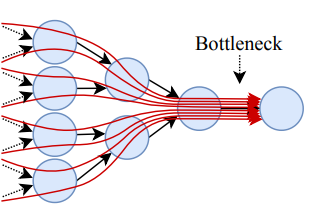

Problem radius of the problem is the required range of interaction between nodes to solve the task. If problem radius is K, the GNN must have at least K layers or else it will suffer from under-reaching. But as number of layers increases, each node's receptive field grows exponentially. As a result, graph will not be able to learn from long-range signals. This phenomenon is called over-squashing.

Problem radius (r) is generally unknown and is approximated by tuning number of layers. In our work, we designed a dataset where we know r theoretically.

# Below code is needed for Google colab

In [1]:
!python -c "import torch; print(torch.__version__)"

2.5.1+cu121


In [2]:
%%capture

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

# Creating synthetic data as in the repository of the over-squashing paper

The following code generates the tree dataset as discussed in the report. The code can be found in data_generation.py and is similar to data generation in the over-squashing paper.

Each graph is a binary tree with root node to be classified and leaves containing information. Each node has two features: index and permutation. Assume $N$ is number of leaves and $\sigma$ is permutation of $N$. Then each node hsa index $i$ as the first feature and $\sigma(i)$ as the second feature. All nodes that are neither root nodes and nor leaves have both features set to 0. Root node has first node set to one of the indices randomly from $1$ to $N$ (let's call it $j$). Second feature is set to zero. The task of the model is to find $\sigma(j)$. Both key and value get passed into nn.Embedding function in model's forward function and then embeddings get concatenated to get x.

In each dataset graphs differ only by $\sigma$. Shape is the same.

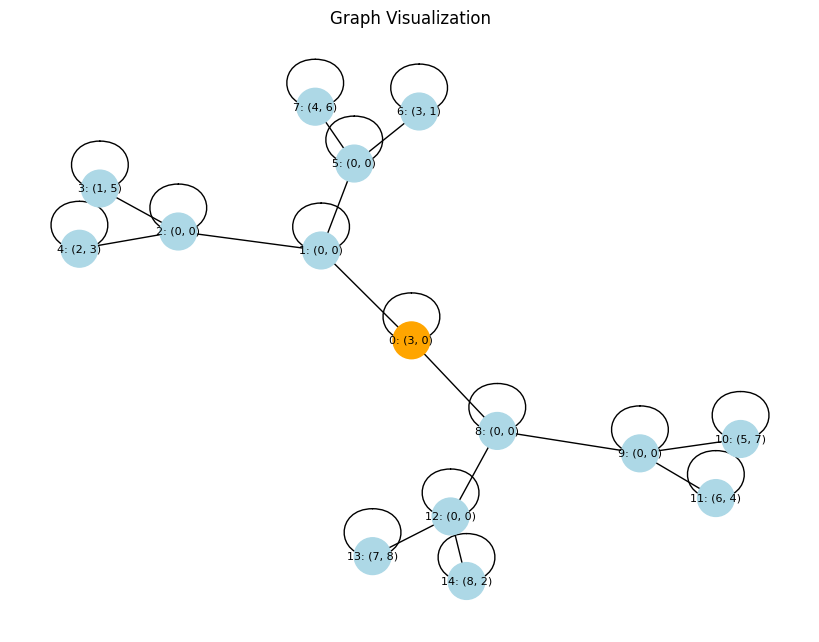

In [40]:
from data_generation import TreeDataset, DictionaryLookupDataset

depth_of_the_tree = 3

t = DictionaryLookupDataset(depth_of_the_tree)
X_train, X_test, dim0, outdim, criterion = t.generate_data(0.8)

In [5]:
# Making sure to not keep too many values
import random
if len(X_train) > 128000:
  X_train = random.sample(X_train, 128000)

In [42]:
sample = X_train[0]

In [43]:
sample

Data(x=[15, 2], edge_index=[2, 29], y=3, root_mask=[15])

In [8]:
def make_sample(depth=3):
  """
  Creates a sample --- needed in case we made
  in place modifications and want to recover original
  """
  depth_of_the_tree = depth

  t = DictionaryLookupDataset(depth_of_the_tree)
  X_train, X_test, dim0, outdim, criterion = t.generate_data(0.8)

  return X_train[0]

## Create a sample highly clustered graph

For analyzing and illustrating theoretical results on more clustered graphs, we created synthetic highly clustered graphs: first several cliques are constructed independently and then one node from each clique is connected with a central node with one edge. You can find the corresponding code in the synthetic\_model.py file. All functions below also work on clustered sample graph.

In [38]:
from data_generation import create_graph_with_cliques_and_central_node

sample_clustered = create_graph_with_cliques_and_central_node()

# Visualization

Following, you can find 3 visualization functions:

- First is directly visualizing the graph, showing its features;
- Second shows shortest path distances from the target node to each node;
- Third shows Markov Chain distanced from the target node to each node. We use distance depth of the tree + 1, as that is what we set our model depth to.

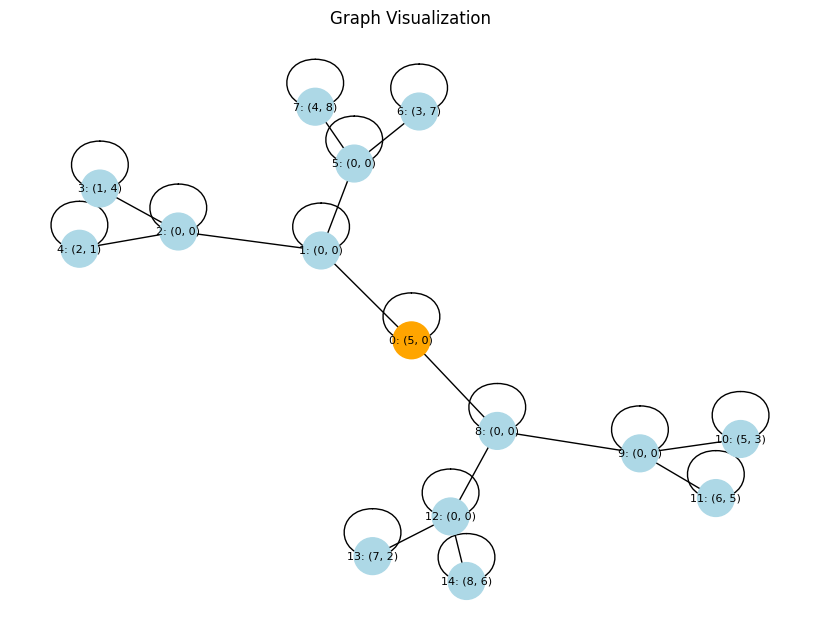

In [49]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(data):
    """
    Visualize the graph
    """
    edge_index = data.edge_index.cpu().numpy()
    features = data.x.cpu().numpy()

    graph = nx.Graph()

    # Add nodes
    for i, feat in enumerate(features):
        graph.add_node(i, label=f"{i}: ({feat[0]}, {feat[1]})")

    # Add edges
    for src, dst in edge_index.T:  # Transpose for correct edge direction
        graph.add_edge(src, dst)

    # Node colors based on features
    node_colors = ['lightblue' for feat in features]
    node_colors[0] = 'orange' # target is orange

    # Draw the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(graph, seed=42)
    nx.draw(graph, pos, with_labels=True, labels=nx.get_node_attributes(graph, 'label'),
            node_color=node_colors, node_size=700, font_size=8, font_color = 'black')

    plt.title("Graph Visualization")
    plt.show()

sample_data = sample
visualize_graph(sample_data)

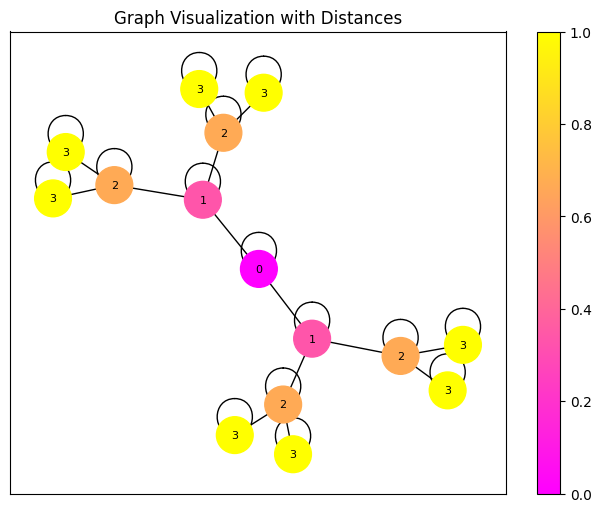

In [52]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def visualize_graph_with_distances(data, target_node=0):
    """
    Visualize the graph with shortest path distances
    """
    edge_index = data.edge_index.cpu().numpy()
    features = data.x.cpu().numpy()

    graph = nx.Graph()

    # add nodes
    for i, feat in enumerate(features):
        graph.add_node(i)

    # Add edges
    for src, dst in edge_index.T:  # Transpose for correct edge direction
        graph.add_edge(src, dst)

    # Calculate shortest path distances from the target node
    distances = nx.single_source_shortest_path_length(graph, target_node)

    # Node colors based on distances
    max_distance = max(distances.values()) if distances else 0
    if max_distance == 0:
        max_distance = 1

    node_colors = [
        distances.get(node, max_distance) / max_distance if node in distances else 1
        for node in graph.nodes
    ]
    labels = {node: str(distances.get(node, 'Inf')) for node in graph.nodes}

    # Draw the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(graph, seed=42)
    nodes = nx.draw_networkx_nodes(
        graph, pos, node_color=node_colors, cmap=plt.cm.spring, node_size=700
    )
    nx.draw_networkx_edges(graph, pos)
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=8)
    plt.title(f"Graph Visualization with Distances")
    plt.colorbar(nodes)

sample_data = sample
visualize_graph_with_distances(sample_data, target_node=0)

For markov chain distance, we tried two definitions: one is distribution after $k$ random walk steps, second is "probability that node y will be visited from node x in k or less steps on a random walk". Values for distant nodes look similar. To change to the second definition, uncomment the `# node_colors = 1 - proba_not_visit` line.

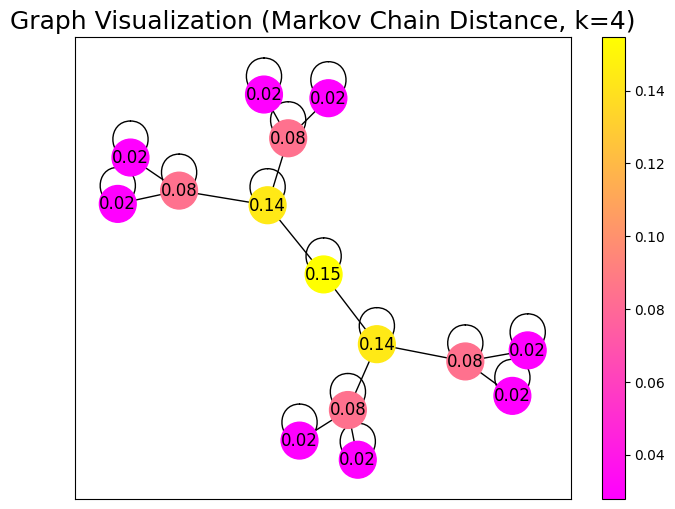

In [53]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def visualize_tree_markov_chain(data, target_node=0, k=3):
    """
    Visualize the graph with Markov Chain distances
    """
    edge_index = data.edge_index.cpu().numpy()
    features = data.x.cpu().numpy()

    graph = nx.Graph()

    # Add nodes
    for i, feat in enumerate(features):
        graph.add_node(i, label=f"{i}: ({feat[0]}, {feat[1]})")

    # Add edges
    for src, dst in edge_index.T:  # Transpose for correct edge direction
        graph.add_edge(src, dst)

    # Transition matrix for MC
    adj_matrix = nx.to_numpy_array(graph)
    transition_matrix = adj_matrix / adj_matrix.sum(axis=1, keepdims=True)
    transition_matrix = np.nan_to_num(transition_matrix)

    # Probability vector
    n_nodes = graph.number_of_nodes()
    prob_vector = np.zeros(n_nodes)
    prob_vector[target_node] = 1.0  # Start from the target node

    proba_not_visit = np.ones(len(prob_vector)) # zero steps - result array - probability of not reaching ith node in any step
    proba_not_visit[0] = 0.0 # we already know first (target) node has been visited

    for step in range(1, k + 1):
        prob_vector = prob_vector @ transition_matrix
        proba_not_visit *= (1-prob_vector)  # Accumulate probabilities - P(visited in exactly one step, visited in exactly 2 steps, etc)

    node_colors = prob_vector
    # node_colors = 1 - proba_not_visit

    distance_labels = {node: str(node_colors[node])[:4] for node in graph.nodes}

    # Visualize
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(graph, seed=42)  # Layout algorithm
    nodes = nx.draw_networkx_nodes(
        graph, pos, node_color=node_colors, cmap=plt.cm.spring, node_size=700
    )
    nx.draw_networkx_edges(graph, pos)
    nx.draw_networkx_labels(graph, pos, labels=distance_labels, font_size=12)

    plt.colorbar(nodes)

    plt.title(f"Graph Visualization (Markov Chain Distance, k={k})", fontsize=18)
    plt.show()

visualize_tree_markov_chain(sample, target_node=0, k=depth_of_the_tree+1)

For clustered sample:

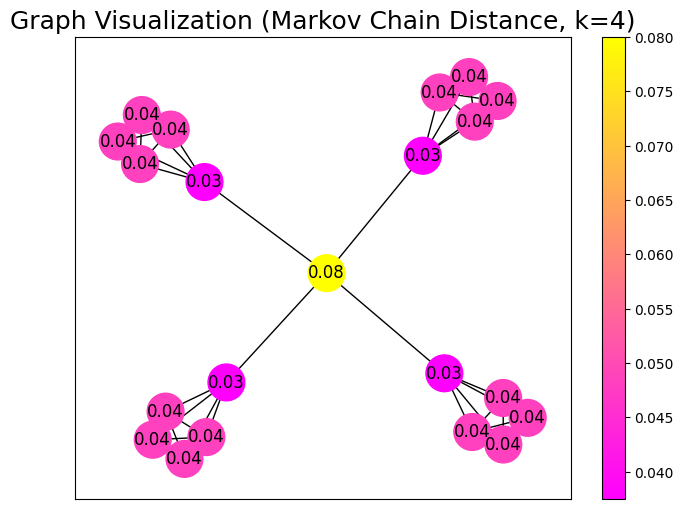

In [56]:
sample_clustered = create_graph_with_cliques_and_central_node()
visualize_tree_markov_chain(sample_clustered, target_node=0, k=depth_of_the_tree+1)

# Graph Modification Functions

Following you will find various graph modification functions and their Markov-Chain distance visualizations.

In [12]:
def add_random_edge(graph):
    """
    Adds one random edge to the graph
    """
    num_nodes = graph.x.size(0)
    edge_index = graph.edge_index

    while True:
        node_a = random.randint(0, num_nodes - 1)
        node_b = random.randint(0, num_nodes - 1)

        if node_a == node_b:
            continue

        new_edge = torch.tensor([[node_a], [node_b]])
        reverse_edge = torch.tensor([[node_b], [node_a]])

        if not ((edge_index == new_edge).all(dim=0).any() or (edge_index == reverse_edge).all(dim=0).any()):
            graph.edge_index = torch.cat([edge_index, new_edge], dim=1)
            break

In [13]:
def add_random_edges(graph, n_edges=None, fraction=None):
    """
    Adds random edges to the graph
    Can specify number of edges of a fraction of number of edges already in the graph
    """
    if fraction and not n_edges:
      n_edges = int(graph.num_edges * fraction)

    for _ in range(n_edges):
      add_random_edge(graph)

Adding 4 random edges:

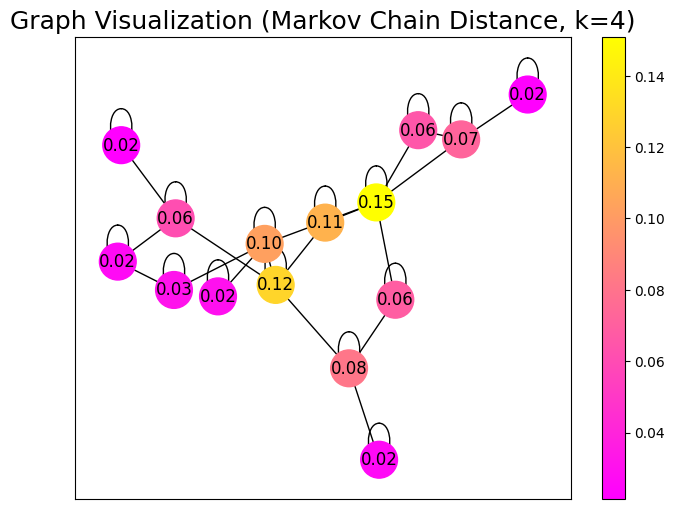

In [14]:
sample = make_sample(3)
add_random_edges(sample, n_edges=4)

visualize_tree_markov_chain(sample, target_node=0, k=depth_of_the_tree+1)

In [15]:
def add_reversed_edges(graph):
    """
    Inplace adds reverse edges
    """
    edge_index = graph.edge_index
    reversed_edges = edge_index.flip(0)

    combined_edges = torch.cat([edge_index, reversed_edges], dim=1)
    unique_edges = torch.unique(combined_edges, dim=1)

    graph.edge_index = unique_edges

In [16]:
def find_best_edge_for_target(data, depth):
    """
    Finds the edges that have to be added so that nodes with the smallest Markov Chain distance with the target get connected
    """
    num_nodes = data.x.size(0)
    target_node = 0

    edge_index = data.edge_index.cpu().numpy()
    features = data.x.cpu().numpy()

    graph = nx.Graph()

    # Add nodes
    for i, feat in enumerate(features):
        graph.add_node(i, label=f"{i}: ({feat[0]}, {feat[1]})")

    # Add edges
    for src, dst in edge_index.T:  # Transpose for correct edge direction
        graph.add_edge(src, dst)

    # Transition matrix for MC
    adj_matrix = nx.to_numpy_array(graph)
    transition_matrix = adj_matrix / adj_matrix.sum(axis=1, keepdims=True)
    transition_matrix = np.nan_to_num(transition_matrix)

    # Probability vector
    n_nodes = graph.number_of_nodes()
    prob_vector = np.zeros(n_nodes)
    prob_vector[target_node] = 1.0  # Start from the target node

    proba_not_visit = np.ones(len(prob_vector)) # zero steps - result array - probability of not reaching ith node in any step
    proba_not_visit[0] = 0.0 # we already know first (target) node has been visited

    for step in range(1, depth + 1):
        prob_vector = prob_vector @ transition_matrix
        proba_not_visit *= (1-prob_vector)  # Accumulate probabilities - P(visited in exactly one step, visited in exactly 2 steps, etc)

    node_colors = 1 - proba_not_visit

    ######
    ## Connect lowest ones to the target node

    lowest_prob_nodes = np.where((node_colors - np.min(node_colors)) < 0.0001)[0]
    best_edges = []
    for node in lowest_prob_nodes:
      best_edges.append((node, target_node))
    return best_edges

In [17]:
def add_edge_in_place(data, edge):
    u, v = edge

    existing_edges = set(tuple(e) for e in data.edge_index.t().tolist())
    if (u, v) in existing_edges or (v, u) in existing_edges:
        return False

    new_edges = torch.tensor([[u, v], [v, u]], dtype=torch.long)
    data.edge_index = torch.cat([data.edge_index, new_edges], dim=1)

    return True

In [18]:
def add_edges_target(graph, n_iters=1):
    for iter in range(n_iters):
      edges_to_add = find_best_edge_for_target(graph, depth=depth_of_the_tree+1)
      print(edges_to_add)
      for edge in edges_to_add:
        add_edge_in_place(graph, edge)

Adding edges based on Markov Chain distance:

[(3, 0), (4, 0), (6, 0), (7, 0), (10, 0), (11, 0), (13, 0), (14, 0)]


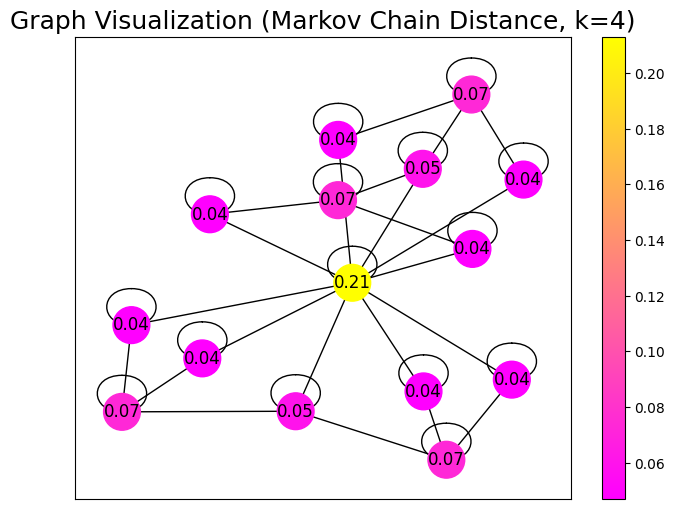

In [19]:
sample = make_sample()
add_edges_target(sample)

visualize_tree_markov_chain(sample, target_node=0, k=depth_of_the_tree+1)

In [20]:
def add_node_and_connect(data, given_nodes, target_node=0):
    """
    Adds virtual node and connects it with given_nodes and target
    """
    num_nodes = data.x.size(0)

    new_node_features = torch.tensor([[0.0, 0.0]], dtype=torch.long)
    data.x = torch.cat([data.x, new_node_features], dim=0)
    new_node_index = num_nodes

    for given_node in given_nodes:
      new_edges = torch.tensor([[given_node, new_node_index], [new_node_index, target_node]], dtype=torch.long)
      data.edge_index = torch.cat([data.edge_index, new_edges], dim=1)

    new_root_mask = torch.cat((data.root_mask, torch.tensor([False])))
    data.root_mask = new_root_mask

In [21]:
def add_virtual_node(graph, nodes_to_add_criterium='markov', nodes_to_add=None):
    """
    Adds virtual node based on nodes_to_add_criterium:

    - all: connects virtual nodes with everything
    - markov: connects virtual nodes with highest markov distance nodes
    """
    if nodes_to_add_criterium == 'markov':
      edges_to_add = find_best_edge_for_target(graph, depth=depth_of_the_tree+1)
      nodes_to_add = [n1 for (n1, _) in edges_to_add]
    elif nodes_to_add_criterium == 'all':
      nodes_to_add = list(range(1, graph.num_nodes))
    else:
      if not nodes_to_add:
        raise Exception("Must give nodes_to_add array if you are not giving criterium")

    add_node_and_connect(graph, nodes_to_add, target_node=0)

Adding virtual node connected to all of the nodes:

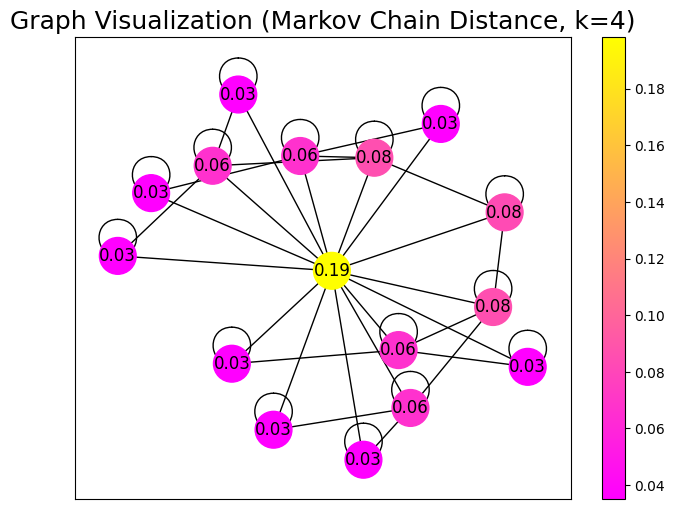

In [22]:
sample = make_sample()
add_virtual_node(sample, nodes_to_add_criterium='all')

visualize_tree_markov_chain(sample, target_node=0, k=depth_of_the_tree+1)

Adding virtual node connected only with highest markov chain distance nodes from the target and to the target:

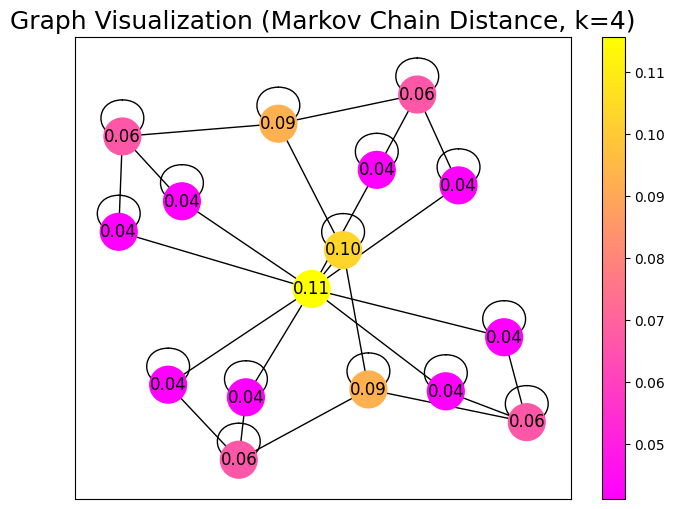

In [23]:
sample = make_sample()
add_virtual_node(sample, nodes_to_add_criterium='markov')

visualize_tree_markov_chain(sample, target_node=0, k=depth_of_the_tree+1)

# Graph Clustering

Following you will find different clusterization algorithms and their visualizations.

In [24]:
sample = make_sample(4)

## Louvain Clustering

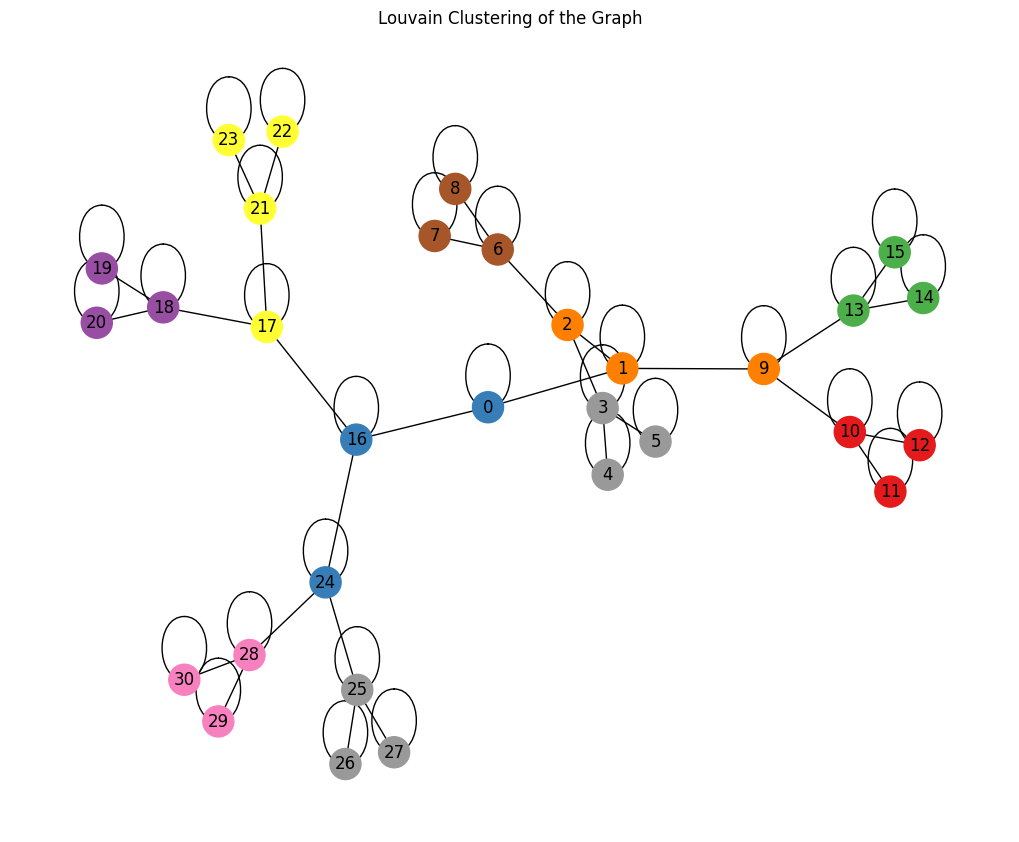

In [25]:
import community.community_louvain as community_louvain

G = nx.Graph()
edges = sample['edge_index'].numpy().T  # Transpose edge_index for easier iteration
for edge in edges:
    G.add_edge(edge[0], edge[1])

partition = community_louvain.best_partition(G)
colors = [partition[node] for node in G.nodes()]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=colors, cmap=plt.cm.Set1, node_size=500)
plt.title("Louvain Clustering of the Graph")
plt.show()

## Spectral Clustering

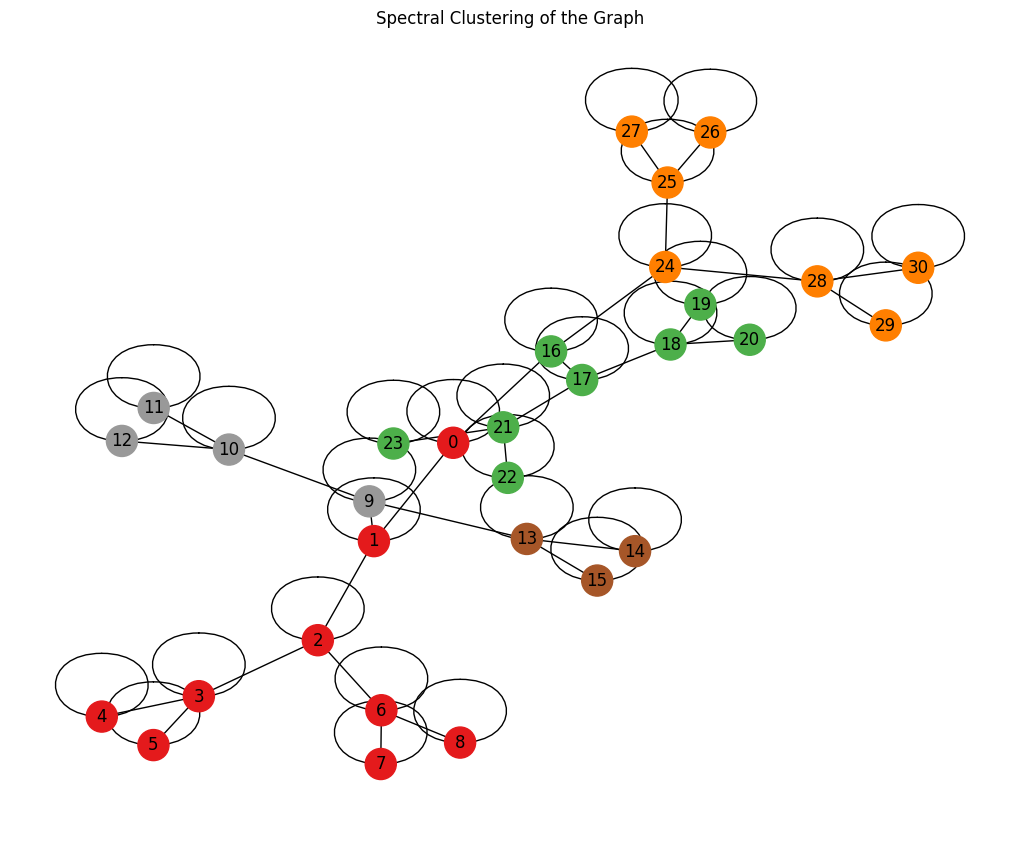

In [26]:
from sklearn.cluster import SpectralClustering

G = nx.Graph()
edges = sample['edge_index'].numpy().T  # Transpose edge_index for easier iteration
for edge in edges:
    G.add_edge(edge[0], edge[1])

adj_matrix = nx.to_numpy_array(G)

sc = SpectralClustering(n_clusters=5, affinity='precomputed', random_state=42)
labels = sc.fit_predict(adj_matrix)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=labels, cmap=plt.cm.Set1, node_size=500)
plt.title("Spectral Clustering of the Graph")
plt.show()

# Hierarchical Clustering

<ipython-input-27-7170afce3f34>:14: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = sch.linkage(dist_matrix, method='ward')


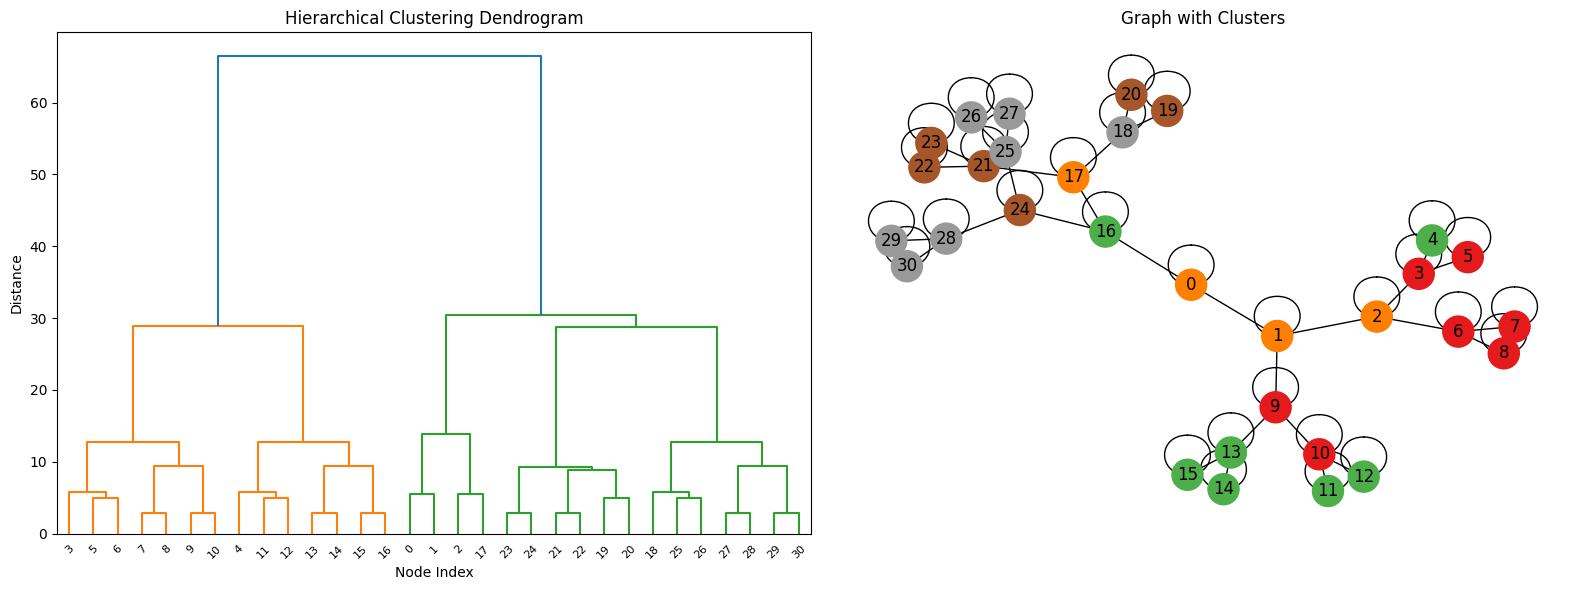

In [27]:
import scipy.cluster.hierarchy as sch

G = nx.Graph()

edges = sample['edge_index'].numpy().T
for edge in edges:
    G.add_edge(edge[0], edge[1])

# Compute the distance matrix (using shortest path distance)
dist_matrix = nx.floyd_warshall_numpy(G)

# Hierarchical clustering
linked = sch.linkage(dist_matrix, method='ward')

# Cutting dendrogram to form clusters
cluster_labels = sch.fcluster(linked, t=5, criterion='maxclust')

colors = [cluster_labels[node] for node in G.nodes()]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].set_title('Hierarchical Clustering Dendrogram')
sch.dendrogram(linked, ax=axes[0])
axes[0].set_xlabel('Node Index')
axes[0].set_ylabel('Distance')

axes[1].set_title('Graph with Clusters')
pos = nx.spring_layout(G)
nx.draw(
    G, pos, ax=axes[1], with_labels=True, node_color=colors, cmap=plt.cm.Set1, node_size=500
)

plt.tight_layout()
plt.show()


# Using clustering to add virtual nodes

Now we use clustering algorithms to add virtual nodes.

In [28]:
def get_louvain_clustering(graph):
  """
  Performs Louvain clustering and returns it
  """
  G = nx.Graph()
  edges = graph['edge_index'].numpy().T
  for edge in edges:
      G.add_edge(edge[0], edge[1])

  partition = community_louvain.best_partition(G)

  reversed_partition = {}

  for key, value in partition.items():
      if value not in reversed_partition:
          reversed_partition[value] = []
      reversed_partition[value].append(key)

  return reversed_partition

In [29]:
sample = make_sample(4)
get_louvain_clustering(sample)

{0: [1, 2, 9],
 2: [0, 16, 24],
 8: [3, 4, 5],
 6: [6, 7, 8],
 1: [10, 11, 12],
 3: [13, 14, 15],
 5: [17, 21, 22, 23],
 4: [18, 19, 20],
 7: [25, 26, 27],
 9: [28, 29, 30]}

In [30]:
def add_undirected_node(data, given_nodes, need_root_mask=True):
    """
    Adds undirected node, helper function for add_virtual_louvain
    """
    num_nodes = data.x.size(0)
    feature_dim = data.x.size(1)
    new_node_features = torch.zeros((1, feature_dim), dtype=data.x.dtype, device=data.x.device)

    data.x = torch.cat([data.x, new_node_features], dim=0)
    new_node_index = num_nodes

    for given_node in given_nodes:
      new_edges = torch.tensor([[given_node, new_node_index], [new_node_index, given_node]], dtype=torch.long)
      data.edge_index = torch.cat([data.edge_index, new_edges], dim=1)

    if need_root_mask:
      new_root_mask = torch.cat((data.root_mask, torch.tensor([False])))
      data.root_mask = new_root_mask

In [31]:
def add_virtual_louvain(graph, method='clique', need_root_mask=True):
  """
  Adds virtual nodes based on Louvain clustering
  """
  num_nodes = graph.x.size(0)
  clustering = get_louvain_clustering(graph)

  # One node per cluster
  for cluster in clustering.keys():
    nodes_to_add = clustering[cluster]
    add_undirected_node(graph, nodes_to_add, need_root_mask)

  if method == 'clique':
    # Create clique between virtual nodes
    # IDEA: not a full clique - take each node with some probability
    new_num_nodes = graph.x.size(0)
    for node1 in range(num_nodes, new_num_nodes):
      for node2 in range(node1 + 1, new_num_nodes):
        new_edges = torch.tensor([[node1, node2], [node2, node1]], dtype=torch.long)
        graph.edge_index = torch.cat([graph.edge_index, new_edges], dim=1)

  elif method == 'circle':
    # Circle connection
    new_num_nodes = graph.x.size(0)
    for node1 in range(num_nodes, new_num_nodes - 1):
      node2 = node1 + 1
      new_edges = torch.tensor([[node1, node2], [node2, node1]], dtype=torch.long)
      graph.edge_index = torch.cat([graph.edge_index, new_edges], dim=1)

    node1 = new_num_nodes - 1
    node2 = num_nodes

    new_edges = torch.tensor([[node1, node2], [node2, node1]], dtype=torch.long)
    graph.edge_index = torch.cat([graph.edge_index, new_edges], dim=1)

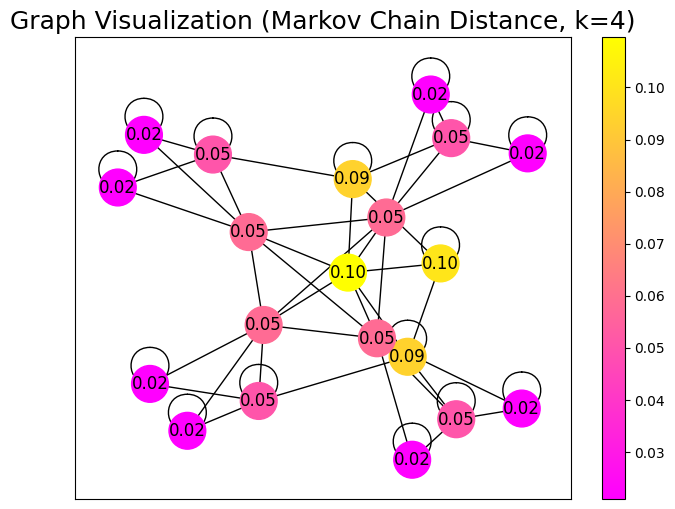

In [32]:
sample = make_sample(3)
add_virtual_louvain(sample, method='clique')
visualize_tree_markov_chain(sample, target_node=0, k=4)

In [33]:
def get_spectral_clustering(graph, num_clusters=5):
  """
  Performs spectral clustering and returns it
  """
  adj_matrix = nx.to_numpy_array(G)

  sc = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', random_state=42)
  labels = sc.fit_predict(adj_matrix)

  partition = {}

  for idx, value in enumerate(labels):
      if value not in partition:
          partition[value] = []
      partition[value].append(idx)

  return partition

In [34]:
def add_virtual_spectral(graph, method='clique', num_clusters=5):
  """
  Adds virtual nodes based on Spectral clustering
  """
  num_nodes = graph.x.size(0)
  clustering = get_spectral_clustering(graph, num_clusters=num_clusters)

  # One node per cluster
  for cluster in clustering.keys():
    nodes_to_add = clustering[cluster]
    add_undirected_node(graph, nodes_to_add)

  if method == 'clique':
    # Create clique between virtual nodes
    # IDEA: not a full clique - take each node with some probability
    new_num_nodes = graph.x.size(0)
    for node1 in range(num_nodes, new_num_nodes):
      for node2 in range(node1 + 1, new_num_nodes):
        new_edges = torch.tensor([[node1, node2], [node2, node1]], dtype=torch.long)
        graph.edge_index = torch.cat([graph.edge_index, new_edges], dim=1)

  elif method == 'circle':
    # Circle connection
    new_num_nodes = graph.x.size(0)
    for node1 in range(num_nodes, new_num_nodes - 1):
      node2 = node1 + 1
      new_edges = torch.tensor([[node1, node2], [node2, node1]], dtype=torch.long)
      graph.edge_index = torch.cat([graph.edge_index, new_edges], dim=1)

    node1 = new_num_nodes - 1
    node2 = num_nodes

    new_edges = torch.tensor([[node1, node2], [node2, node1]], dtype=torch.long)
    graph.edge_index = torch.cat([graph.edge_index, new_edges], dim=1)

In [35]:
get_spectral_clustering(sample)

{0: [0, 1, 3, 5, 6, 7, 8, 9, 10],
 1: [2, 17, 19, 20, 21, 22, 23, 24],
 4: [4, 11, 13, 14],
 3: [12, 15, 16],
 2: [18, 25, 26, 27, 28, 29, 30]}

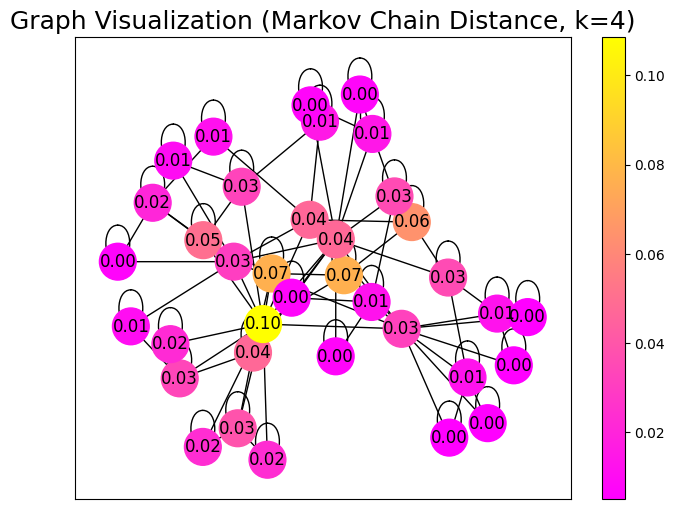

In [36]:
sample = make_sample(4)
add_virtual_spectral(sample, num_clusters=5)
visualize_tree_markov_chain(sample, target_node=0, k=depth_of_the_tree+1)

# Model

Below code only needs X_train and X_test to be defined. You have to construct the graph data as desired from the above code and then run the code below to train and test the model.

In [ ]:
X_train
X_test

We use GraphModel from the over-squashing paper repository to replicate results as closely as possible.

In [ ]:
from synthetic_model import GraphModel

We use GCN model.

In [ ]:
import torch
import torch_geometric.nn as pyg_nn

class GCN:
    @staticmethod
    def get_layer(in_dim, out_dim):
        return pyg_nn.GCNConv(in_dim, out_dim)


gnn_type = GCN  # Using Graph Convolutional layers
num_layers = depth_of_the_tree + 1  # Number of layers = tree depth + 1
dim0 = dim0  # Input features dimension = number of leaf nodes (as one hot encoding)
h_dim = 32  # Hidden layer dimension
out_dim = outdim  # Output dimension (classification)
last_layer_fully_adjacent = False
unroll = False
layer_norm = True # Layer norm
use_activation = True # Activation function
use_residual = True  # Redidual connections

model = GraphModel(gnn_type=gnn_type, num_layers=num_layers, dim0=dim0, h_dim=h_dim, out_dim=out_dim,
                   last_layer_fully_adjacent=last_layer_fully_adjacent, unroll=unroll, layer_norm=layer_norm,
                   use_activation=use_activation, use_residual=use_residual)


Training and testing. Note: we test on training set to measure over-squashing.

In [37]:
import torch.optim as optim
from torch_geometric.data import DataLoader
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)  # Parallelize the model across available GPUs

train_loader = DataLoader(X_train, batch_size=32, shuffle=True)
test_loader = DataLoader(X_train, batch_size=32, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 200):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        out = model(batch)
        loss = criterion(out, batch.y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss / len(train_loader)}')

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch)
        pred = out.argmax(dim=1)
        correct += (pred == batch.y).sum().item()
        total += len(batch.y)

accuracy = correct / total
print(f'Train Accuracy: {accuracy * 100:.2f}%')

If we are curious about performance on the testing set.

In [ ]:
test_loader = DataLoader(X_test, batch_size=32, shuffle=False)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch)
        pred = out.argmax(dim=1)
        correct += (pred == batch.y).sum().item()
        total += len(batch.y)

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Graph metrics

Instead of wiring nodes to one node using markov chain distances, we had an idea to find global properties of a graph which would be optimized by rewiring the graph from any node to another.

### Some interesting graph related measures to optimize:
- ASPL: $$
ASPL = \frac{1}{n(n-1)} \sum_{u,v} d(u, v)
$$

- Graph efficiency: $$
E = \frac{1}{n(n-1)} \sum_{u \neq v} \frac{1}{d(u, v)}
$$
- Average commute time: $$
ACT = \frac{1}{n(n-1)} \sum_{u \neq v} C(u, v)
$$ where $
C(u, v) = 2m \cdot R(u, v)
$ with $R$ is effective resistance between the nodes: $$
R(u, v) = \mathbf{L}^+_{uu} + \mathbf{L}^+_{vv} - 2\mathbf{L}^+_{uv}
$$

One problem with this approach is that search space is very large. There are $\binom{n}{2} = \frac{n(n-1)}{2}$ potential edges that have to be calculated. We bypass this problem by only searching between random subset of edges. Logic for this is that uniformly randomly chosen nodes between the whole graph will give some connections which will connect the graph better, so by iterating over this and considering different random subset each time, we can get interesting results.

One good point about these metrics is that in first two we can choose a custom distance function to optimize (e.g. can be a Markov Chain distance in our case).

The problem for using this for synthetic dataset is that model does not care about the general graph connectivity: it only cares about the graph connectivity related to the target node. Because of this, these methods did not give a better performance.

For protein datasets we tested and average_commute_time approach takes a lot of time, so it not practical. We proposed another greedy method for real-life datasets to optimize ASPL and graph efficiency, which is detailed in the report. Code is in Real_data.ipynb notebook.

In [ ]:
def compute_average_shortest_path_length(data):
    num_nodes = data.x.size(0)

    edge_index = data.edge_index
    adj = torch.zeros((num_nodes, num_nodes))
    adj[edge_index[0], edge_index[1]] = 1
    adj[edge_index[1], edge_index[0]] = 1  # For undirected graphs

    G = nx.from_numpy_array(adj.numpy())
    shortest_paths = dict(nx.all_pairs_shortest_path_length(G))

    total_distance = 0
    num_pairs = 0

    for u in range(num_nodes):
        for v in range(u + 1, num_nodes):  # Only compute for u < v to avoid redundancy
            if v in shortest_paths[u]:
                total_distance += shortest_paths[u][v]
                num_pairs += 1

    aspl = total_distance / num_pairs
    return aspl

In [ ]:
def compute_graph_efficiency(data):
    num_nodes = data.x.size(0)

    edge_index = data.edge_index
    adj = torch.zeros((num_nodes, num_nodes))
    adj[edge_index[0], edge_index[1]] = 1
    adj[edge_index[1], edge_index[0]] = 1

    G = nx.from_numpy_array(adj.numpy())
    shortest_paths = dict(nx.all_pairs_shortest_path_length(G))

    efficiency_sum = 0
    num_pairs = 0

    for u in range(num_nodes):
        for v in range(u + 1, num_nodes):  # Only compute for u < v to avoid redundancy
            if v in shortest_paths[u] and shortest_paths[u][v] > 0:
                efficiency_sum += 1 / shortest_paths[u][v]
                num_pairs += 1

    graph_efficiency = efficiency_sum / num_pairs
    return graph_efficiency


In [ ]:
def compute_average_commute_time(data):
    num_nodes = data.x.size(0)

    edge_index = data.edge_index
    adj = torch.zeros((num_nodes, num_nodes))
    adj[edge_index[0], edge_index[1]] = 1
    adj[edge_index[1], edge_index[0]] = 1

    degree = torch.diag(adj.sum(dim=1))

    # Compute the Laplacian matrix (L = D - A)
    laplacian = degree - adj

    # Compute the pseudoinverse of the Laplacian
    laplacian_pinv = torch.linalg.pinv(laplacian)

    commute_times = []
    for u in range(num_nodes):
        for v in range(u + 1, num_nodes):  # Only compute for u < v to avoid redundancy
            C_uv = laplacian_pinv[u, u] + laplacian_pinv[v, v] - 2 * laplacian_pinv[u, v]
            commute_times.append(C_uv.item())

    average_commute_time = sum(commute_times) / len(commute_times)
    return average_commute_time

In [ ]:
from itertools import combinations
from torch_geometric.data import Data

def find_best_edge_to_add(data, sample_size=100):
    num_nodes = data.x.size(0)
    existing_edges = set(tuple(edge) for edge in data.edge_index.t().tolist())

    # Generate all possible edges (u, v) where u != v and not already in the graph
    all_possible_edges = set(combinations(range(num_nodes), 2))
    candidate_edges = all_possible_edges - existing_edges

    original_act = compute_average_commute_time(data)

    best_edge = None
    best_act = original_act

    if len(candidate_edges) > sample_size:
        candidate_edges = random.sample(candidate_edges, sample_size)

    # Evaluate adding each candidate edge
    for u, v in candidate_edges:
        # Temporarily add the edge
        new_edge_index = torch.cat(
            [data.edge_index, torch.tensor([[u, v], [v, u]], dtype=torch.long)], dim=1
        )

        # Create a temporary graph with the new edge
        temp_data = Data(x=data.x, edge_index=new_edge_index)

        # Calculate the average commute time
        new_act = compute_average_commute_time(temp_data)

        # Check if this addition reduces the ACT the most
        if new_act < best_act:
            best_act = new_act
            best_edge = (u, v)

    return best_edge, best_act